# Kaggle Contest - House Prices

Importing likely packages needed

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
import scipy as stats
from scipy.stats import norm, skew

## Import data

In [73]:
train = pd.read_csv('train.csv')
train_ID = train['Id']
train = train.drop(['Id'], axis = 1)
test = pd.read_csv('test.csv')
test_ID = test['Id']
test = test.drop(['Id'], axis = 1)
combine = train.drop(['SalePrice'], axis = 1)
combine = pd.concat([combine, test]).reset_index(drop = True)
ntrain = train.shape[0]
ntest = test.shape[0]

In [74]:
combine.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


Check if SalePrice needs to be transformed.

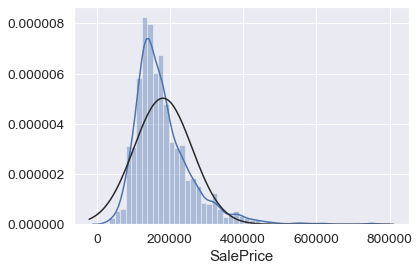

In [75]:
#distplot
sns.distplot(train['SalePrice'], fit=norm)

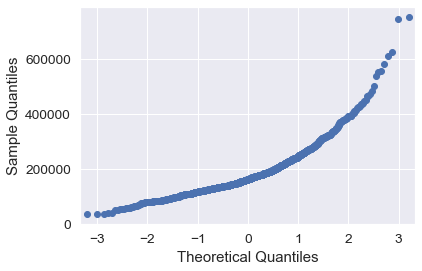

In [76]:
#Get also the QQ-plot
sm.qqplot(train['SalePrice'])
plt.show()

In [77]:
#transform SalePrice using np.log1p
train['SalePrice'] = np.log1p(train['SalePrice'])

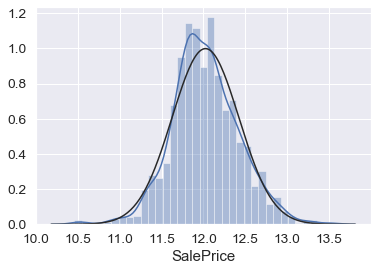

In [78]:
#distplot
sns.distplot(train['SalePrice'], fit=norm)

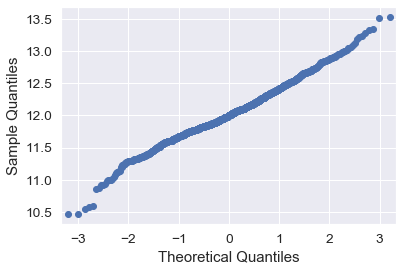

In [79]:
#Get also the QQ-plot
sm.qqplot(train['SalePrice'])
plt.show()

Transformation worked. SalesPrice now normally distributed

### Check shape of Data Frames

In [80]:
train.shape

(1460, 80)

In [81]:
test.shape

(1459, 79)

In [82]:
combine.shape

(2919, 79)

In [83]:
colnames = pd.DataFrame(train.columns, columns = ['ColumnNames'])

In [84]:
colnames

,ColumnNames
0,MSSubClass
1,MSZoning
2,LotFrontage
3,LotArea
4,Street
...,...
75,MoSold
76,YrSold
77,SaleType
78,SaleCondition


## Correlation of variables with SalesPrice|

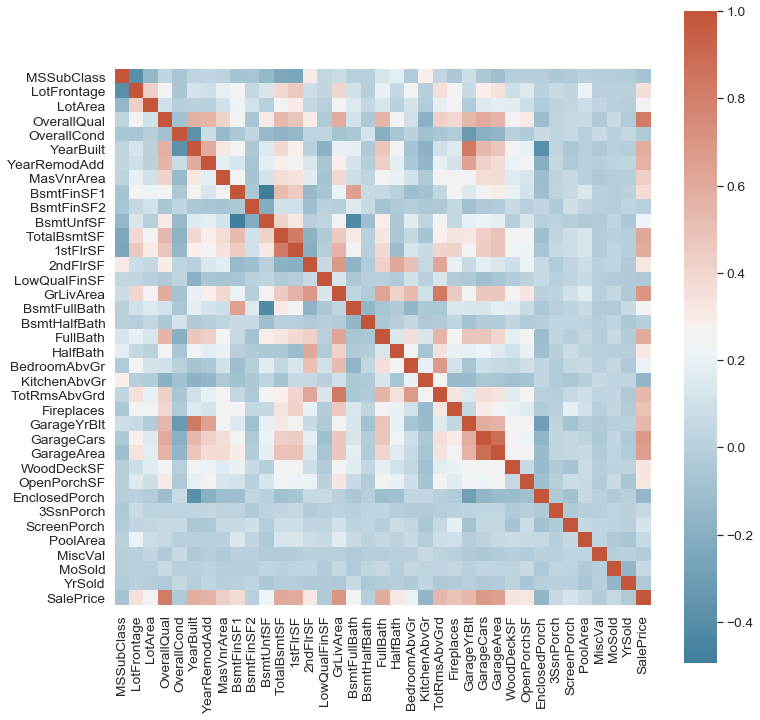

In [85]:
train_corr = train.corr(method = 'pearson')
f, ax = plt.subplots(figsize = (12,12))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(train_corr, cmap = cmap, square = True)

### Let's check corrplot with SalePrice to see what correlates best with SalePrice

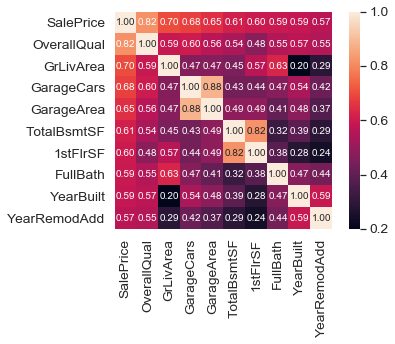

In [86]:
k = 10 #number of variables for heatmap
cols = train_corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Looks like OverallQual, GrLivArea, GarageCars, Garage Area are best.

For Garage variables, looks like maybe just keeping Garage Cars is best. Doubt having both variables matters.

For the area variables (GrLivArea, TotalBsmtSF, 1stFlrSF), should just create a variable for TotalSF.

## Missing Values

Let's check through all of the variables to see how many are missing.

In [87]:
pct_miss = combine.isnull().sum()/len(combine)
pct_miss = pd.DataFrame(pct_miss)
pct_miss.columns = ['PctMissing']
pct_miss = pct_miss.sort_values(by = ['PctMissing'], ascending = False)
pct_miss.head(34)

,PctMissing
PoolQC,0.996574
MiscFeature,0.964029
Alley,0.932169
Fence,0.804385
FireplaceQu,0.486468
LotFrontage,0.166495
GarageYrBlt,0.054471
GarageFinish,0.054471
GarageQual,0.054471
GarageCond,0.054471


34 predictors with at least some missing vlaues. Let's knock them out one at a time.

PoolQC , Fence, FirePlaceQual, GarageYrBuilt, GarageCond, GarageQual, BsmtExposure, BsmtQual, BsmtFinType1, BsmtFinType2, MasVnrType, MiscFeature, Alley 'NA' = 'None'. Let's just replace it with none.


In [88]:
for col in ('PoolQC', 'Fence', 'FireplaceQu', 'GarageYrBlt', 'GarageCond', 'GarageQual', 'BsmtExposure',
           'BsmtQual', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MiscFeature', 'Alley', 'GarageFinish',
           'GarageType', 'BsmtCond'):
    combine[col] = combine[col].fillna('None')

In [89]:
pct_miss = combine.isnull().sum()/len(combine)
pct_miss = pd.DataFrame(pct_miss)
pct_miss.columns = ['PctMissing']
pct_miss = pct_miss.sort_values(by = ['PctMissing'], ascending = False)
pct_miss.head(15)

,PctMissing
LotFrontage,0.166495
MasVnrArea,0.007879
MSZoning,0.001370
BsmtFullBath,0.000685
BsmtHalfBath,0.000685
Utilities,0.000685
Functional,0.000685
GarageArea,0.000343
Electrical,0.000343
TotalBsmtSF,0.000343


LotFrontage has 16% zero. Let's just put the median for the neighbood LotFrontage for the NAs.

In [90]:
combine['LotFrontage'] = combine.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

All the Bsmt continuous variables above where there is NA means no basement. Can replace with zero.

In [91]:
for col in ('TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1', 'BsmtFullBath', 
            'BsmtHalfBath', 'GarageCars', 'GarageArea', 'MasVnrArea'):
    combine[col] = combine[col].fillna(0)

In [92]:
pct_miss = combine.isnull().sum()/len(combine)
pct_miss = pd.DataFrame(pct_miss)
pct_miss.columns = ['PctMissing']
pct_miss = pct_miss.sort_values(by = ['PctMissing'], ascending = False)
pct_miss.head(9)

,PctMissing
MSZoning,0.001370
Utilities,0.000685
Functional,0.000685
Electrical,0.000343
KitchenQual,0.000343
Exterior1st,0.000343
Exterior2nd,0.000343
SaleType,0.000343
BsmtFullBath,0.000000


In [93]:
#fill MSZoning with mode
combine['MSZoning'] = combine['MSZoning'].fillna(combine['MSZoning'].mode()[0])
#fill Exterior1st and Exterior2nd with mode
combine['Exterior1st'] = combine['Exterior1st'].fillna(combine['Exterior1st'].mode()[0])
combine['Exterior2nd'] = combine['Exterior2nd'].fillna(combine['Exterior2nd'].mode()[0])

In [94]:
#fill Functional with 'Typ'
combine['Functional'] = combine['Functional'].fillna('Typ')

In [95]:
#fill the rest with mode
for col in ('Utilities', 'Electrical', 'SaleType', 'KitchenQual'):
    combine[col] = combine[col].fillna(combine[col].mode()[0])


In [96]:
pct_miss = combine.isnull().sum()/len(combine)
pct_miss = pd.DataFrame(pct_miss)
pct_miss.columns = ['PctMissing']
pct_miss = pct_miss.sort_values(by = ['PctMissing'], ascending = False)
pct_miss.head(3)

,PctMissing
MSSubClass,0.0
BedroomAbvGr,0.0
GarageType,0.0


All NAs gone.

## Predictors to remove / create

Should look to the garage variables to drop some of these. Seems that GarageCars should suffice.

From the GrLivArea + 1stFlrSF + 2ndFlrSF make a variable for TotalSF

In [97]:
combine['GarageArea'] = combine.drop(['GarageArea'], axis = 1)
combine['TotalSF'] = combine['GrLivArea'] + combine['1stFlrSF'] + combine['2ndFlrSF']

## Variable Transformation

Some variables are dtype float64 or int64, but are really categorical.

In [98]:
print(combine['MSSubClass'].dtype)
print(combine['OverallCond'].dtype)
print(combine['MoSold'].dtype)
print(combine['YrSold'].dtype)

int64
int64
int64
int64


In [99]:
items = ('MSSubClass', 'OverallCond', 'MoSold', 'YrSold')
for cols in items:
    combine[cols] = combine[cols].astype(str)

### Label Encode all variables that are levels.

In [100]:
items = ('Condition1', 'Condition2', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'PoolQC', 'Fence', 'SaleCondition')
for cols in items:
    lbl = LabelEncoder()
    lbl.fit(list(combine[cols].values))
    combine[cols] = lbl.transform(list(combine[cols].values))

In [101]:
print('Shape of combine {}'.format(combine.shape))

Shape of combine (2919, 80)


Check the skew of the numericals

In [102]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics
numericals = combine.dtypes[combine.dtypes != 'object'].index
skew_num = combine[numericals].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)

In [103]:
skewness = pd.DataFrame({'Skew' :skew_num})
skewness.head(10)

,Skew
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
Condition2,12.060093
3SsnPorch,11.376065
KitchenAbvGr,4.302254
BsmtFinSF2,4.146143
EnclosedPorch,4.003891
ScreenPorch,3.946694


In [104]:
skewness = skewness[abs(skewness) > 0.75]
print('There are a total of {} variables to transform due to skewness'.format(len(skewness)))

There are a total of 42 variables to transform due to skewness


In [105]:
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for features in skewed_features:
    combine[features] = boxcox1p(combine[features], lam)

In [106]:
combine = pd.get_dummies(combine)

In [107]:
combine.shape

(2919, 407)

Separate train and test dataframes

In [108]:
train2 = combine[:ntrain]
test2 = combine[ntrain:]
y = train['SalePrice']

### Build Models

In [109]:
import pip
pip.main(['install', 'lightgbm'])
pip.main(['install', 'xgboost'])
pip.main(['install', 'KernelRidge'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
ERROR: Could not find a version that satisfies the requirement KernelRidge (from versions: none)
ERROR: No matching distribution found for KernelRidge


1

In [110]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [111]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train2.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

LASSO Regression :
This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's Robustscaler() method on pipeline

In [112]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

Elastic Net Regression :
again made robust to outliers

In [113]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

Gradient Boosting Regression :
With huber loss that makes it robust to outliers

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

XGBoost :

In [114]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

Ligbt GBM

In [115]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [116]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1253 (0.0151)



In [117]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

C:\Users\ericp\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.021975577693369885, tolerance: 0.018002191385488822
  positive)
C:\Users\ericp\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02619464860133114, tolerance: 0.018373605848561597
  positive)


ElasticNet score: 0.1253 (0.0151)



In [118]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[21:24:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:24:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:24:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

In [119]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

In [120]:
train2.head()

,LotFrontage,LotArea,Condition1,Condition2,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,5.831328,19.212182,1.194318,1.194318,2.440268,14.187527,14.187527,8.059126,1.194318,1.820334,...,0,0,0,0,0,0,0,0,0,1
1,6.221214,19.712205,0.730463,1.194318,2.259674,14.145138,14.145138,0.000000,1.540963,1.820334,...,0,0,0,0,0,0,0,0,0,1
2,5.914940,20.347241,1.194318,1.194318,2.440268,14.184404,14.185966,7.646538,1.194318,1.820334,...,0,0,0,0,0,0,0,0,0,1
3,5.684507,19.691553,1.194318,1.194318,2.440268,14.047529,14.135652,0.000000,1.540963,1.820334,...,0,0,0,0,0,0,0,0,0,1
4,6.314735,21.325160,1.194318,1.194318,2.602594,14.182841,14.182841,9.391827,1.194318,1.820334,...,0,0,0,0,0,0,0,0,0,1


In [121]:
X, y = train2, train['SalePrice']

In [122]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [123]:
model_xgb.fit(X,y)

[21:24:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1.7817, missing=nan, monotone_constraints='()',
             n_estimators=2200, n_jobs=8, nthread=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=7, reg_alpha=0.464,
             reg_lambda=0.8571, scale_pos_weight=1, silent=1, subsample=0.5213,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [196]:
preds = pd.Series(model_xgb.predict(test2))

In [198]:
test_ID = pd.Series(test_ID)
preds = pd.Series(np.exp(preds))

In [126]:
final = pd.DataFrame({'ID':test_ID, 'SalePrice': preds})

In [208]:
final.head()

,ID,SalePrice
0,1461,124029.218750
1,1462,165597.250000
2,1463,184201.046875
3,1464,195971.640625
4,1465,189991.859375


In [128]:
final.to_csv('housingpreds', index=False)

In [ ]:
#top 21%

In [129]:
#blended models
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RepeatedKFold
from numpy import mean
from numpy import std

In [130]:
# get a list of models to evaluate
def get_models():
    models = dict()
    models['xgb'] = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
    models['lgb'] = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
    models['lasso'] = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
    return models

In [131]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    scores = np.sqrt(-scores)
    return scores

In [132]:
#set data X, y
X, y = train2, train['SalePrice']
results, names = list(), list()
models = get_models()
#evaluate models
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(names)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))


>xgb 0.290 (0.015)
>lgb 0.289 (0.016)
>lasso 0.285 (0.013)


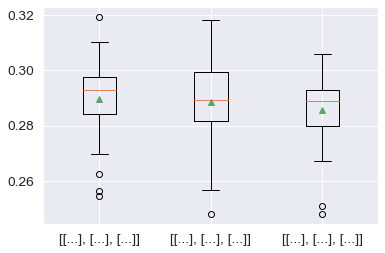

In [133]:
#plot performance
plt.boxplot(results, labels = names, showmeans = True)
plt.show()

In [141]:
# get a stacking ensemble of models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('xgb',xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)))
    level0.append(('lgb',lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)))
    level0.append(('lasso',make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

In [186]:
#redo get_models with stacking
def get_models():
    models = dict()
    models['xgb'] = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
    models['lgb'] = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
    models['lasso'] = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
    models['stacking'] = get_stacking()
    return models

In [187]:
#get models
models = get_models()

In [188]:
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>xgb 0.290 (0.015)
>lgb 0.289 (0.016)
>lasso 0.285 (0.013)
>stacking 0.281 (0.015)


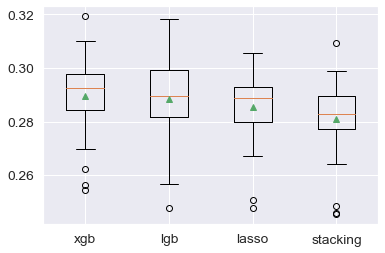

In [189]:
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [ ]:
#looks like stacking does improve best model.

In [190]:
#create stacking predictions
model = get_stacking()

In [191]:
model.fit(X,y)

[21:48:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[21

StackingRegressor(cv=5,
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.4603,
                                            gamma=0.0468, gpu_id=None,
                                            importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.05,
                                            max_delta_step=None, max_depth=3,
                                            min_child_weight=1.7817,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estim...
                                                    

In [200]:
y_pred = model.predict(test2)

In [201]:
y_pred

array([11.72320597, 11.96849569, 12.12095463, ..., 12.02474679,
       11.69573181, 12.32652449])

In [206]:
test_ID = pd.Series(test_ID)
y_pred = pd.Series(np.exp(y_pred))

In [207]:
y_pred

0       123402.416147
1       157707.241794
2       183680.777812
3       196374.970284
4       196978.306787
            ...      
1454     80906.137978
1455     81592.006908
1456    166832.699570
1457    120058.188214
1458    225601.283447
Length: 1459, dtype: float64

In [209]:
final_blend = pd.DataFrame({'ID':test_ID, 'SalePrice': preds})
final_blend.head()

,ID,SalePrice
0,1461,123402.416147
1,1462,157707.241794
2,1463,183680.777812
3,1464,196374.970284
4,1465,196978.306787


In [212]:
final_blend.to_csv('housingpreds2', index=False)

In [211]:
pwd

'C:\\Users\\ericp\\houseprices'

In [ ]:
#577 out of 5122
#top 11%